#### <a>Objective: To predict if the client will subscribe a Bank Term Deposit.

### <a>Bank Marketing

#### <a>Abstract:
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

#### <a>Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

#### <a>Attribute Information:
#### <a>Input variables:
    
    Bank Client Data:
    
    1 - age (numeric)<br>
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
    4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
    5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')
    
    Related with the last contact of the current campaign:
    
    8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
    9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
    10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
    11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    
    Other attributes:
    
    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
    14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    
    Social and Economic context attributes
    
    16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
    17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
    18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
    19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
    20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

#### <a>Output variable (desired target):
    
    21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

<a><b>Data Source:</b></a>http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

#### <a>Importing Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
import cufflinks as cf
from plotly.offline import iplot
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

#### <a>Defining UDFs - User Defined Funcions 

In [2]:
#UDF for statistical summary for continuous variables
def cont_ss(a):
    return pd.Series([a.count(), a.isnull().sum(), a.sum(), a.mean(), a.median(),  
                      a.std(), a.var(), a.min(), a.quantile(0.01), a.quantile(0.99), a.max()], 
                  index = ['COUNT', 'MISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                                'P99' ,'MAX'])

In [3]:
#UDF for statistical summary for categorical variables
def cat_ss(a):
    Mode = a.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([a.count(), a.isnull().sum(), len(np.unique(a)), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/a.count()), 2)], 
                      index = ['COUNT', 'MISS', 'UNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# UDF for creating dummies
def dummy_var(data, col_name):
    dummy_col = pd.get_dummies(data[col_name], prefix = col_name, drop_first = True)
    data = pd.concat([data, dummy_col], axis = 1)
    data.drop(col_name, axis = 1, inplace = True )
    return data

#### <a>Loading Data

In [5]:
df_cust = pd.read_csv('Data Set/bank-additional.csv', sep = ';')

#### <a>Understanding the data

In [6]:
#Data View
df_cust.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [7]:
#Data Information
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

#### <a>Statistical Report

In [8]:
#Continuous variables
df_cust.select_dtypes(['int64','float64']).apply(cont_ss)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
COUNT,4119.000000,4.119000e+03,4119.000000,4.119000e+03,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4.119000e+03
MISS,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SUM,165228.000000,1.057710e+06,10451.000000,3.955979e+06,784.000000,350.000000,385454.802000,-166815.800000,14916.364000,2.128074e+07
MEAN,40.113620,2.567881e+02,2.537266,9.604222e+02,0.190337,0.084972,93.579704,-40.499102,3.621356,5.166482e+03
MEDIAN,38.000000,1.810000e+02,2.000000,9.990000e+02,0.000000,1.100000,93.749000,-41.800000,4.857000,5.191000e+03
STD,10.313362,2.547037e+02,2.568159,1.919228e+02,0.541788,1.563114,0.579349,4.594578,1.733591,7.366790e+01
VAR,106.365426,6.487399e+04,6.595442,3.683436e+04,0.293535,2.443327,0.335645,21.110142,3.005339,5.426960e+03
MIN,18.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,-3.400000,92.201000,-50.800000,0.635000,4.963600e+03
P1,24.000000,1.100000e+01,1.000000,3.000000e+00,0.000000,-3.400000,92.201000,-50.000000,0.677000,4.963600e+03
P99,68.000000,1.231660e+03,13.000000,9.990000e+02,3.000000,1.400000,94.601000,-26.900000,4.968000,5.228100e+03


In [9]:
#Categorical Variable
df_cust.select_dtypes('object').apply(cat_ss)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
COUNT,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
MISS,0,0,0,0,0,0,0,0,0,0,0
UNIQUE,12,4,8,3,3,3,2,10,5,3,2
MODE,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
FREQ,1012,2509,1264,3315,2175,3349,2652,1378,860,3523,3668
PERCENT,24.57,60.91,30.69,80.48,52.8,81.31,64.38,33.45,20.88,85.53,89.05


In [10]:
#Checking duplicates records
df_cust.duplicated().sum()

0

#### <a>Explorartory Data Analysis

no     3668
yes     451
Name: y, dtype: int64


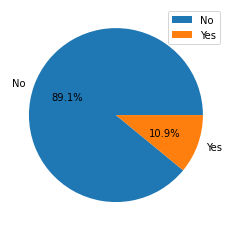

In [11]:
#Number of customers with Bank Term Deposit Subscription
print(df_cust['y'].value_counts())
plt.pie(df_cust['y'].value_counts(), labels = ['No','Yes'], autopct='%.1f%%')
plt.legend()
plt.show()

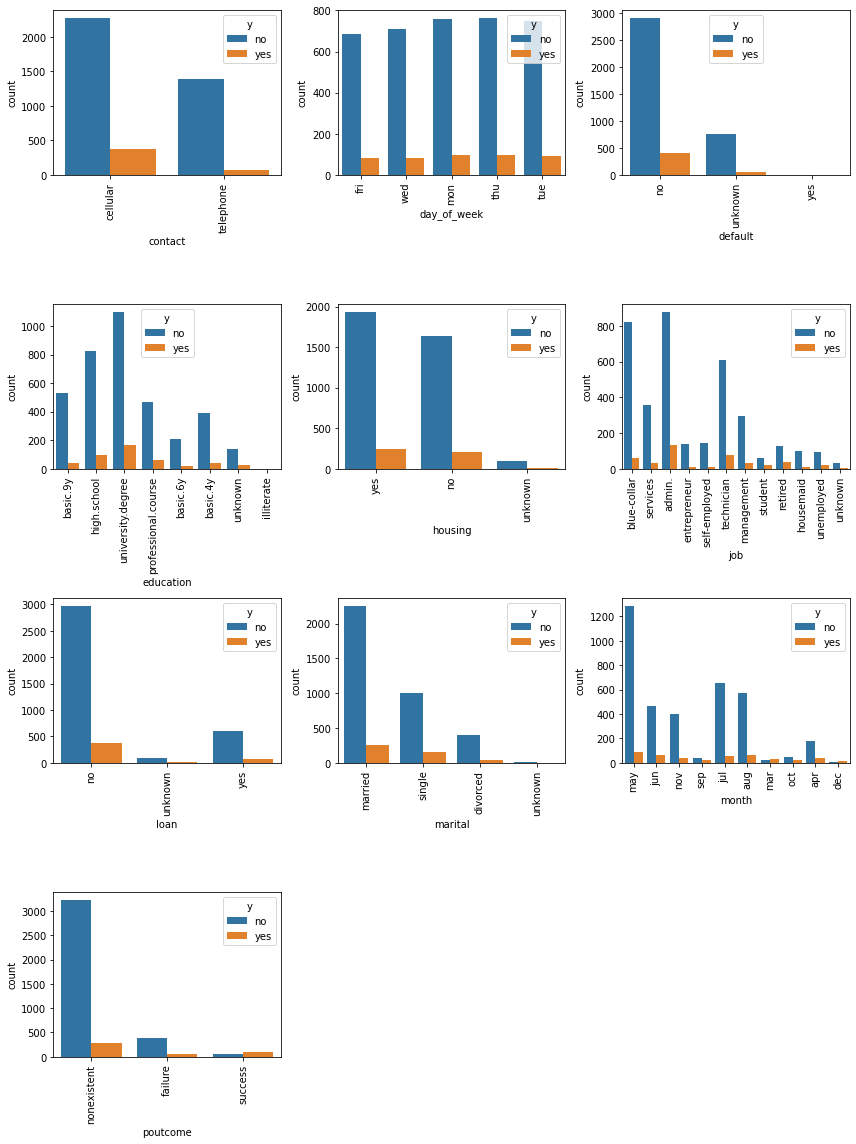

In [12]:
#Categorical features impact on target variable y
plt.figure(figsize = (12,16))
for a, b in enumerate(df_cust.select_dtypes('object').columns.difference(['y'])):
    plt.subplot(4, 3, a+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.countplot(x = b, data = df_cust, hue = 'y')
    plt.xticks(rotation = 90)
    plt.tight_layout()

#### Observations

- Customers who were contacted by cellular have more percentage of subscription
- Customers without credit subscribed more
- Customer education is also a deciding factor for subscription 
- Customer job title also impact the subscription decision of customers
- High number of contacts are made in may, jun, july, aug resulting in more subscriptions
- Previous markteing campaign also impact the subscription decision of customers


     y    age  duration  campaign   pdays  previous  emp.var.rate  \
0   no  39.90    219.41      2.61  982.76      0.14          0.24   
1  yes  41.89    560.79      1.98  778.72      0.59         -1.18   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0           93.60         -40.59       3.80      5175.50  
1           93.42         -39.79       2.15      5093.12  


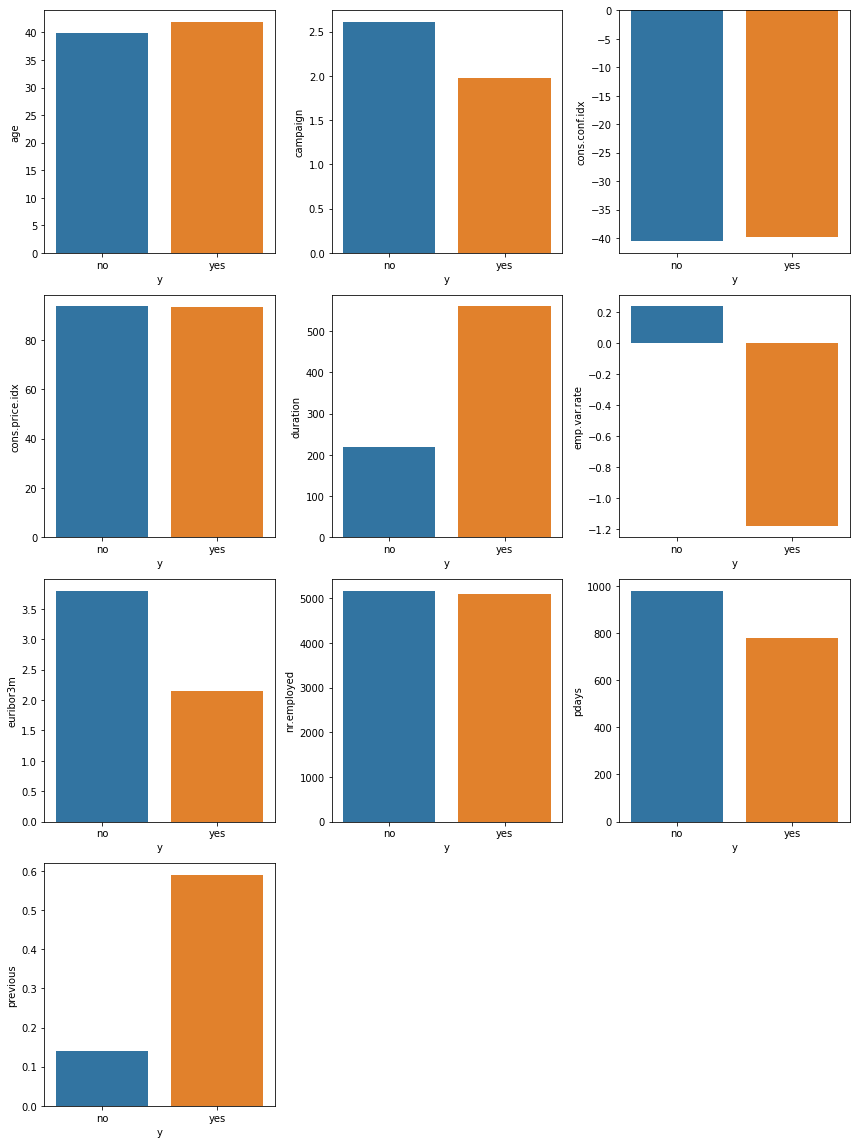

In [13]:
#Continuous features impact on target variable y
print(df_cust.groupby('y').mean().round(2).reset_index())
plt.figure(figsize = (12,16))
for a, b in enumerate(df_cust.select_dtypes(['int64','float64']).columns.difference(['y'])):
    plt.subplot(4, 3, a+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = 'y', y = b, data = df_cust.groupby('y').mean().round(2).reset_index())
    plt.tight_layout()
plt.show()    

#### Observations 

- Customers with subscription have high average age than those of without subscription
- Customers having subscription were contacted less number of times
- Customers with subscription have long last contact durtion
- Customers with subscription have low Euribor 3 month rate
- Customers having subscription were more recently contacted
- Customers with subscription were contacted more before current campaign

#### Data Preparation

In [14]:
#Changing 'yes' and 'no' to 1 and 0 in target variable
df_cust['y'] = np.where(df_cust['y'] == 'yes', 1, 0)

In [15]:
df_cust.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [16]:
#Changing categorical variables to numerical
for col in df_cust.select_dtypes('object').columns:
    df_cust = dummy_var(df_cust, col)

In [17]:
df_cust.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0


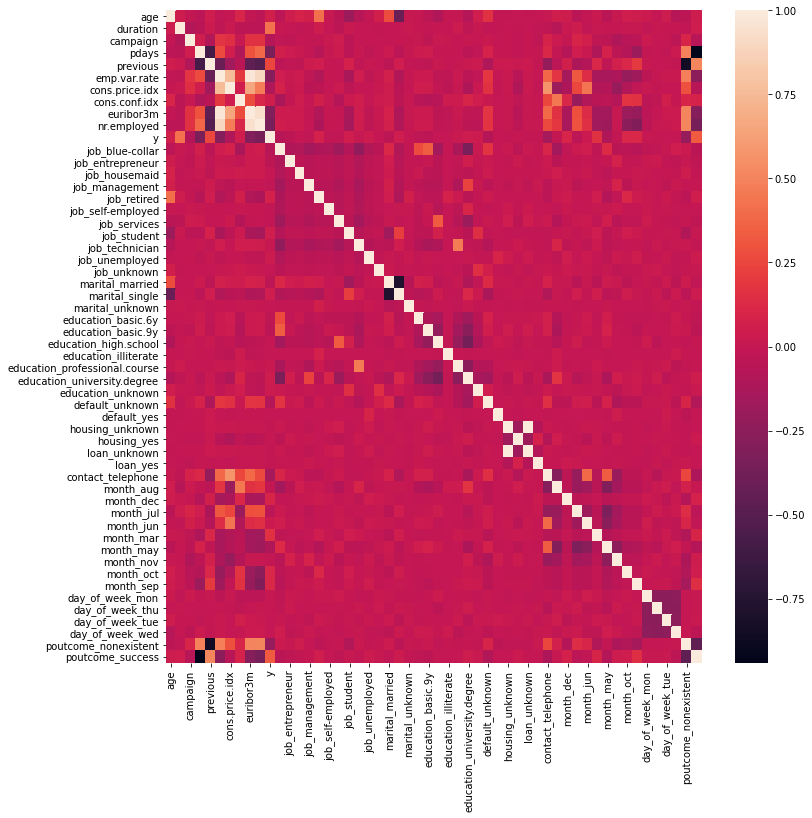

In [18]:
#Visualizing correlation between variables
plt.figure(figsize = (12,12))
sns.heatmap(df_cust.corr())
plt.show()

#### <a>Prediction Model - If a client will subscribe to Bank Term Deposit

In [19]:
#Getting independent and target variables
feat_col = df_cust.columns.difference(['y'])
target = 'y'

In [20]:
#Selecting important features by using RFE
c_rf = RandomForestClassifier(random_state = 89)
fe = RFE(estimator = c_rf, n_features_to_select = 10)
fe.fit(df_cust[feat_col], df_cust[target])

print(fe.support_)
print(fe.ranking_)

[ True  True  True  True False False False False False False False  True
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False  True  True]
[ 1  1  1  1 14  8  7 11 13 16 44  1 34 18 10 43 15  5 26  2  1 40  3 17
 36 37 21 20 29 22 31  6 30 41 38 12  4  9 42 32 39 28 25 23 27 33 24 35
  1  1 19  1  1]


In [21]:
#Getting selected features for modelling
feat_imp = feat_col[fe.support_]
feat_imp

Index(['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration',
       'euribor3m', 'nr.employed', 'pdays', 'poutcome_success', 'previous'],
      dtype='object')

In [22]:
#Standardizing the dataset
sc = StandardScaler()
sc_x = pd.DataFrame(sc.fit_transform(df_cust[feat_imp]))
sc_x.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.980752,-0.209228,-1.240939,-1.185448,0.903952,-1.331707,-0.914779,0.201031,-0.188958,-0.351356
1,-0.107991,0.569634,0.892269,0.715193,0.350300,0.711698,0.332862,0.201031,-0.188958,-0.351356
2,-1.465619,-0.598660,-0.283172,1.528273,-0.116966,0.773427,0.836535,0.201031,-0.188958,-0.351356
3,-0.204965,0.180203,-0.283172,1.528273,-0.941553,0.771697,0.836535,0.201031,-0.188958,-0.351356
4,0.667795,-0.598660,-0.326707,-0.655478,-0.780563,0.328632,0.398028,0.201031,-0.188958,-0.351356


In [23]:
#Getting train and test dataset
x_train, x_test, y_train, y_test = train_test_split(sc_x, df_cust[target],
                                                   test_size = 0.3, random_state = 89)

In [24]:
#Checking for imbalanced data
y_train.value_counts()

0    2561
1     322
Name: y, dtype: int64

As we have only 322 values for '1' i.e. yes - subscribed which is very less compared to 2561 values for '0' i.e. no - not subscribed. This makes the precision and recall of model prediction for predicting '1' very poor. We want have a good precision and good recall on both the classification labels. So, it is neccessary to have balanced data.

In [25]:
#Rebalancing the data using under-sampling
print('Original dataset shape {}'.format(Counter(y_train)))

us = RandomUnderSampler(random_state = 89, sampling_strategy=0.3)
x_train, y_train = us.fit_sample(x_train, y_train)

print('Oversampled dataset shape {}'.format(Counter(y_train)))

Original dataset shape Counter({0: 2561, 1: 322})
Oversampled dataset shape Counter({0: 1073, 1: 322})


#### <a>Bagging Model

In [26]:
#Getting parameters for best fit using GridSeachCV

pg = {'n_estimators' : range(10,100,20),
          'learning_rate': [10 ** x for x in range(-2, 2)],
          'max_depth'    : range(0,11,2)
          
              }

gscv_xgb = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic',
                                                  random_state = 89,
                                                  use_label_encoder = False), 
                     param_grid = pg,
                     scoring = 'roc_auc',
                     cv = 5,
                     n_jobs = -1).fit(x_train, y_train)

[13:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
gscv_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 90}

In [28]:
gscv_xgb.best_score_

0.9437875336465316

In [29]:
#Rebuilding model with best fit parameters
cl_xgb = gscv_xgb.best_estimator_
cl_xgb.fit(x_train, y_train)

#Making prediction on train and test data
train_pred_xgb = cl_xgb.predict(x_train)
test_pred_xgb = cl_xgb.predict(x_test)

#Calculating log loss
log_xgb = metrics.log_loss(y_test, cl_xgb.predict_proba(x_test))

[13:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(y_train, train_pred_xgb))
print("AUC      : ", metrics.roc_auc_score(y_train, cl_xgb.predict_proba(x_train)[:,1]))
print("")
print("Test Dataset")
acc_score_xgb = metrics.accuracy_score(y_test, test_pred_xgb)
print("Accuracy : ", acc_score_xgb)
print("AUC      : ", metrics.roc_auc_score(y_test, cl_xgb.predict_proba(x_test)[:,1]))
print("Log Loss : ", log_xgb)

Model Performance
Train Dataset
Accuracy :  0.9146953405017921
AUC      :  0.9643595190821577

Test Dataset
Accuracy :  0.8948220064724919
AUC      :  0.9303971205086727
Log Loss :  0.22488195214663184


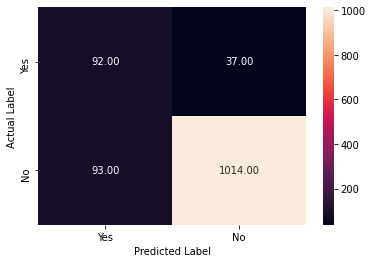

In [31]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_xgb, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Yes', 'No'], yticklabels = ['Yes', 'No'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [32]:
#Classification metrics scores of the model
print(metrics.classification_report(y_test, test_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1107
           1       0.50      0.71      0.59       129

    accuracy                           0.89      1236
   macro avg       0.73      0.81      0.76      1236
weighted avg       0.92      0.89      0.90      1236



#### <a>K Neighbors Model

In [33]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_neighbors' : range(1,11,1)
              }

gscv_knn = GridSearchCV(estimator = KNeighborsClassifier(), 
                     param_grid = pg,
                     scoring = 'roc_auc',
                     cv = 5,
                     n_jobs = -1).fit(x_train, y_train)

In [34]:
gscv_knn.best_params_

{'n_neighbors': 10}

In [35]:
gscv_knn.best_score_

0.9221972177871031

In [36]:
#Using best fit parameters to fit the model
cl_knn = gscv_knn.best_estimator_
cl_knn.fit(x_train, y_train)

#Making prediction on train and test data
train_pred_knn = cl_knn.predict(x_train)
test_pred_knn = cl_knn.predict(x_test)

#Calculating log loss
log_knn = metrics.log_loss(y_test, cl_knn.predict_proba(x_test))

In [37]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(y_train, train_pred_knn))
print("AUC      : ", metrics.roc_auc_score(y_train, cl_knn.predict_proba(x_train)[:,1]))
print("")
print("Test Dataset")
acc_score_knn = metrics.accuracy_score(y_test, test_pred_knn)
print("Accuracy : ", acc_score_knn)
print("AUC      : ", metrics.roc_auc_score(y_test, cl_knn.predict_proba(x_test)[:,1]))
print("Log Loss : ", log_knn)

Model Performance
Train Dataset
Accuracy :  0.8831541218637993
AUC      :  0.9539559370893704

Test Dataset
Accuracy :  0.8907766990291263
AUC      :  0.8990357345433919
Log Loss :  0.5123648091108095


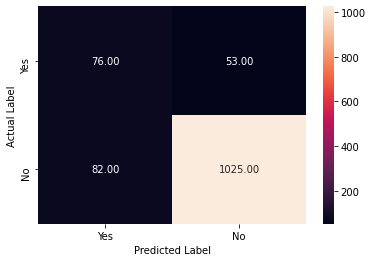

In [38]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_knn, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Yes', 'No'], yticklabels = ['Yes', 'No'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [39]:
#Classification metrics scores of the model
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1107
           1       0.48      0.59      0.53       129

    accuracy                           0.89      1236
   macro avg       0.72      0.76      0.73      1236
weighted avg       0.90      0.89      0.90      1236



#### <a>Random Forest Model

In [40]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_estimators' : [100,300,500]
              }

gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state = 89), 
                     param_grid = pg,
                     scoring = 'roc_auc',
                     cv = 5,
                     n_jobs = -1).fit(x_train, y_train)

In [41]:
gscv_rf.best_params_

{'n_estimators': 100}

In [42]:
gscv_rf.best_score_

0.9410172694481131

In [43]:
#Using best fit parameters to fit the model
cl_rf = gscv_rf.best_estimator_
cl_rf.fit(x_train, y_train)

#Making prediction on train and test data
train_pred_rf = cl_rf.predict(x_train)
test_pred_rf = cl_rf.predict(x_test)

#Calculating log loss
log_rf = metrics.log_loss(y_test, cl_rf.predict_proba(x_test))

In [44]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(y_train, train_pred_rf))
print("AUC      : ", metrics.roc_auc_score(y_train, cl_rf.predict_proba(x_train)[:,1]))
print("")
print("Test Dataset")
acc_score_rf = metrics.accuracy_score(y_test, test_pred_rf)
print("Accuracy : ", acc_score_rf)
print("AUC      : ", metrics.roc_auc_score(y_test, cl_rf.predict_proba(x_test)[:,1]))
print("Log Loss : ", log_rf)

Model Performance
Train Dataset
Accuracy :  1.0
AUC      :  1.0

Test Dataset
Accuracy :  0.88915857605178
AUC      :  0.9108562145052974
Log Loss :  0.2920648412614465


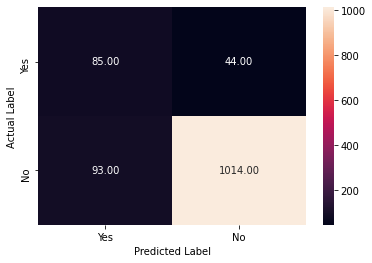

In [45]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_rf, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Yes', 'No'], yticklabels = ['Yes', 'No'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [46]:
#Classification metrics scores of the model
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1107
           1       0.48      0.66      0.55       129

    accuracy                           0.89      1236
   macro avg       0.72      0.79      0.75      1236
weighted avg       0.91      0.89      0.90      1236



#### <a>Artificial Neural Network (ANN) Model

In [47]:
#Shape of Input Data
x_train.shape

(1395, 10)

In [48]:
#Initializing Neural Network
se = Sequential()
#Adding input layer
se.add(Dense(10, activation = 'relu', input_dim = 10))
#Adding hidden layer
se.add(Dense(7, activation = 'relu'))
#Adding one more hidden layer
se.add(Dense(4, activation = 'relu'))
#Adding output layer
se.add(Dense(1, activation = 'sigmoid'))

In [49]:
#Getting model summary
se.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Configuration of the model
se.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 10,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 7,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initial

In [51]:
#Compiling and fitting the model
se.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
se.fit(x_train, y_train, epochs = 20, batch_size = 5, validation_data = (x_test, y_test))

Epoch 1/20
279/279 [==============================] - 2s 4ms/step - loss: 0.6315 - accuracy: 0.7361 - val_loss: 0.3226 - val_accuracy: 0.9037
Epoch 2/20
279/279 [==============================] - 1s 2ms/step - loss: 0.3606 - accuracy: 0.8468 - val_loss: 0.2544 - val_accuracy: 0.9005
Epoch 3/20
279/279 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8554 - val_loss: 0.2539 - val_accuracy: 0.8892
Epoch 4/20
279/279 [==============================] - 1s 2ms/step - loss: 0.2748 - accuracy: 0.8641 - val_loss: 0.2459 - val_accuracy: 0.8819
Epoch 5/20
279/279 [==============================] - 1s 2ms/step - loss: 0.2811 - accuracy: 0.8673 - val_loss: 0.2399 - val_accuracy: 0.8819
Epoch 6/20
279/279 [==============================] - 1s 2ms/step - loss: 0.2914 - accuracy: 0.8676 - val_loss: 0.2413 - val_accuracy: 0.8754
Epoch 7/20
279/279 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.8897 - val_loss: 0.2330 - val_accuracy: 0.8738
Epoch 

In [52]:
#Predicted values for train and test data
se_train_pred = (se.predict(x_train)>0.5).astype('int64')[:,0]
se_test_pred = (se.predict(x_test)>0.5).astype('int64')[:,0]

#Log Loss of the model
log_se = metrics.log_loss(y_test, se_test_pred)

#Evaluating model performance
print("Model Performance")
print("Train Dataset -")
print('Accuracy : ', metrics.accuracy_score(y_train, se_train_pred))
print('AUC      : ', metrics.roc_auc_score(y_train, se.predict(x_train)[:,0]))
print("")
print('Test Dataset -')
acc_se = metrics.accuracy_score(y_test, se_test_pred)
print('Accuracy : ', acc_se)
print('AUC      : ', metrics.roc_auc_score(y_test, se.predict(x_test)[:,0]))
print('Log Loss : ', log_se)

Model Performance
Train Dataset -
Accuracy :  0.8903225806451613
AUC      :  0.9473381070082718

Test Dataset -
Accuracy :  0.8673139158576052
AUC      :  0.9158070908874463
Log Loss :  4.58289844404033


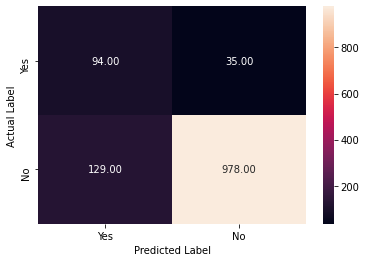

In [53]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, se_test_pred, labels = [1,0])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', xticklabels = ['Yes', 'No'], yticklabels = ['Yes', 'No'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [54]:
#classification metrics scores of the model
print(metrics.classification_report(y_test, se_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1107
           1       0.42      0.73      0.53       129

    accuracy                           0.87      1236
   macro avg       0.69      0.81      0.73      1236
weighted avg       0.91      0.87      0.88      1236



#### <a>Comparing accuracy and log loss metrics of each model

In [55]:
#Getting accuracy and log loss for each model
metric_data = pd.DataFrame({'Classifiers' : ['XGBClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'ArtificialNeuralNetwork'],
                        'Accuracy %' : [acc_score_xgb, acc_score_knn, acc_score_rf, acc_se],
                        'Log_Loss' : [log_xgb, log_knn, log_rf, log_se]})

In [56]:
metric_data['Accuracy %'] = metric_data['Accuracy %'].apply(lambda x : round((x*100),2))

In [57]:
metric_data

,Classifiers,Accuracy %,Log_Loss
0,XGBClassifier,89.48,0.224882
1,KNeighborsClassifier,89.08,0.512365
2,RandomForestClassifier,88.92,0.292065
3,ArtificialNeuralNetwork,86.73,4.582898


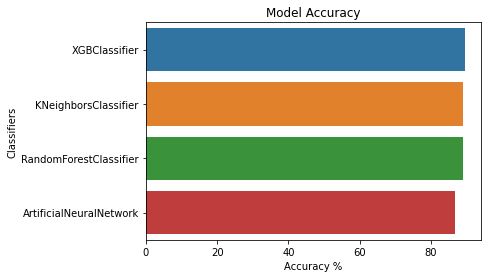

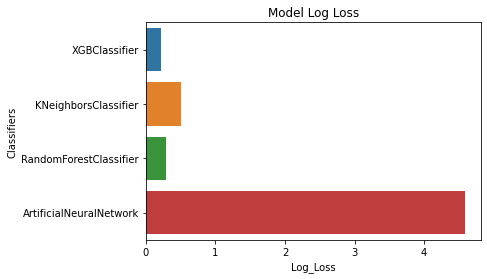

In [58]:
#Visualizing each model's accuracy and log loss metric
sns.barplot(data = metric_data, x = metric_data['Accuracy %'], y = metric_data.Classifiers)
plt.title('Model Accuracy')
plt.show()

sns.barplot(data = metric_data, x = metric_data['Log_Loss'], y = metric_data.Classifiers)
plt.title('Model Log Loss')
plt.show()

ANN model has the highest log loss of 3.96 following K Neighbors Model has log loss of 0.51. As the model predicted probability diverges more from the true label, the entropy loss increases and greater is the log loss. So, we want lower log loss indicating the prediction of the model is more accurate. From the above graph, we can say that XGBoost Model and Random Forest Model provides better prediction for the subscription of the Bank Term Deposit.